# Supermarket Sales

Description:
* 1000 rows, 5 parent and 5 child features

Parent features:
* Branch, City, Customer type, Gender, Product line, Unit price

Child features:
* Quantity, Tax 5%, Total, Date, Time, Payment

Source: https://www.kaggle.com/aungpyaeap/supermarket-sales

In [1]:
import sys
sys.path.append("C:/Users/notes/grab")

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
sm = pd.read_csv("../data/supermarket.csv")

In [4]:
parent = sm[['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Unit price']]
parent.head()

,Branch,City,Customer type,Gender,Product line,Unit price
0,A,Yangon,Member,Female,Health and beauty,74.69
1,C,Naypyitaw,Normal,Female,Electronic accessories,15.28
2,A,Yangon,Normal,Male,Home and lifestyle,46.33
3,A,Yangon,Member,Male,Health and beauty,58.22
4,A,Yangon,Normal,Male,Sports and travel,86.31


In [5]:
child = sm[['Quantity', 'Tax 5%', 'Total', 'Date', 'Time', 'Payment']]
child.head()

,Quantity,Tax 5%,Total,Date,Time,Payment
0,7,26.1415,548.9715,1/5/2019,13:08,Ewallet
1,5,3.8200,80.2200,3/8/2019,10:29,Cash
2,7,16.2155,340.5255,3/3/2019,13:23,Credit card
3,8,23.2880,489.0480,1/27/2019,20:33,Ewallet
4,7,30.2085,634.3785,2/8/2019,10:37,Ewallet


In [6]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(sparse=False)
t_parent = enc.fit_transform(parent[['Branch', 'City', 'Customer type', 'Gender', 'Product line']])

X = np.append(t_parent, parent[['Unit price']], axis=1)

In [7]:
enc = OneHotEncoder(sparse=False)
t_child = enc.fit_transform(child[['Payment']])

child_month = pd.to_datetime(child['Date']).dt.month
child_day = pd.to_datetime(child['Date']).dt.day
child_hour = pd.to_datetime(child['Time']).dt.hour
child_dt = pd.concat([child_month, child_day, child_hour], axis=1).values

y = np.concatenate([child[['Quantity', 'Tax 5%', 'Total']], t_child, child_dt], axis=1)

In [8]:
import tensorflow as tf

X = X.astype(np.float32)
y = y.astype(np.float32)
dataset = tf.data.Dataset \
    .from_tensor_slices((X, y)) \
    .shuffle(X.size).batch(32)

In [9]:
from model.gmm import GMM

# Build GMM
gmm = GMM(x_features=X.shape[1],
          y_features=y.shape[1],
          n_components=100,
          n_hidden=50)
gmm.fit(dataset, epochs=1000, plot=True, verbose=True, logdir="gmm_supermarket")
y_hat = gmm.sample(X)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
0 [NLL: 384.3710021972656]
100 [NLL: 22.86732292175293]
200 [NLL: 22.759855270385742]
300 [NLL: 22.50528335571289]
400 [NLL: 20.681753158569336]
500 [NLL: 22.468502044677734]
600 [NLL: 21.469959259033203]
700 [NLL: 21.089616775512695]
800 [NLL: 21.208724975585938]
900 [NLL: 21.310155868530273]


In [10]:
%load_ext tensorboard
%tensorboard --logdir experiments/logs/gmm_supermarket

Reusing TensorBoard on port 6006 (pid 94676), started 20:46:54 ago. (Use '!kill 94676' to kill it.)

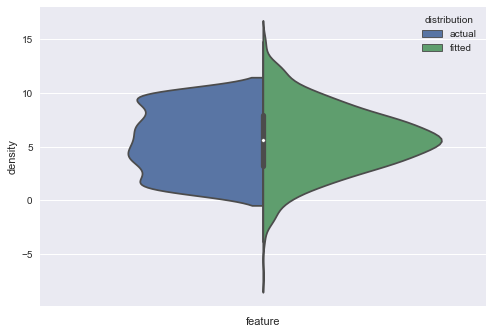

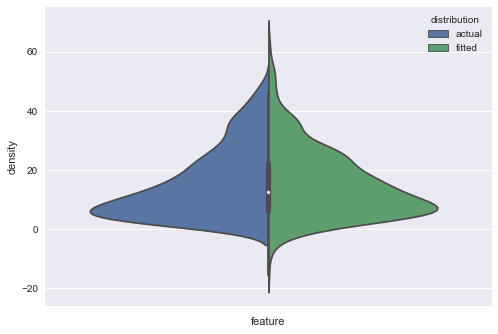

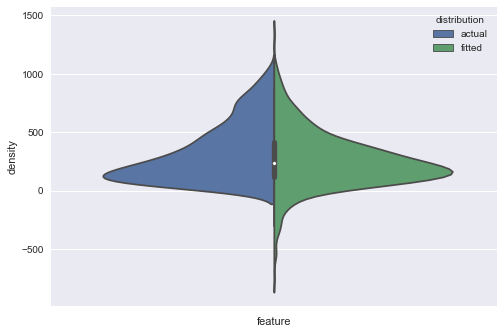

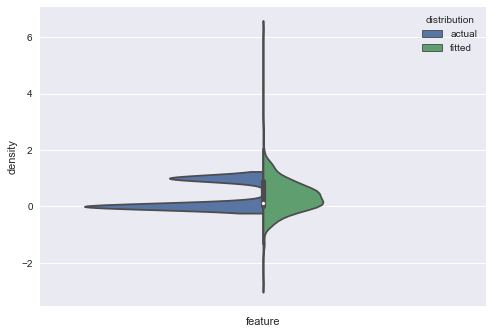

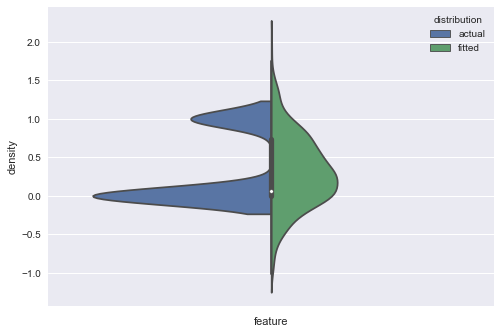

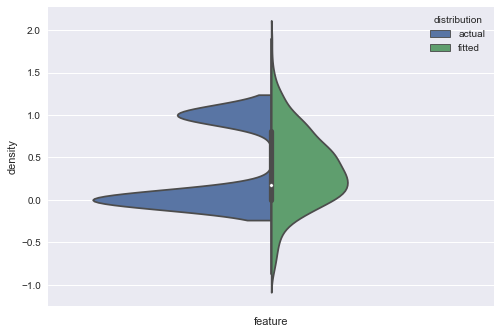

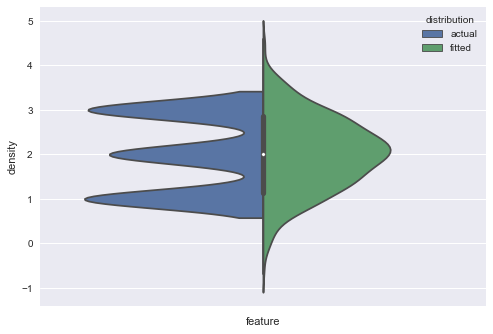

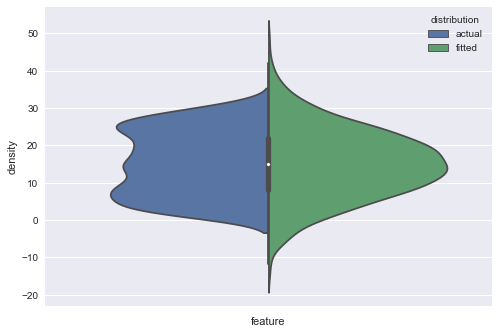

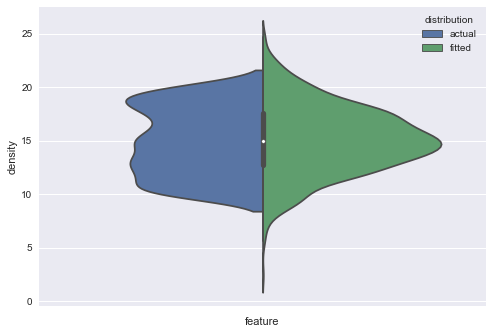

In [11]:
from visualisation.visualisation import Visualisation

gmm_viz = Visualisation(gmm, X, y)
for i in range(y.shape[1]):
    gmm_viz.plot_violin(y[:,i], y_hat[:,i])

In [19]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=8)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: 0.0
JS: 0.0


In [20]:
from model.cgan import CGAN

cgan = CGAN(x_features=X.shape[1],
            y_features=y.shape[1],
            latent_dim=32)

cgan.fit(dataset, epochs=1000, verbose=True, logdir="cgan_supermarket")

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 17)]         0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 16)           528         input_2[0][0]                    
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 16)           288         input_3[0][0]                    
____________________________________________________________________________________________

In [21]:
%load_ext tensorboard
%tensorboard --logdir logs/cgan_supermarket

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 4160), started 21:38:30 ago. (Use '!kill 4160' to kill it.)

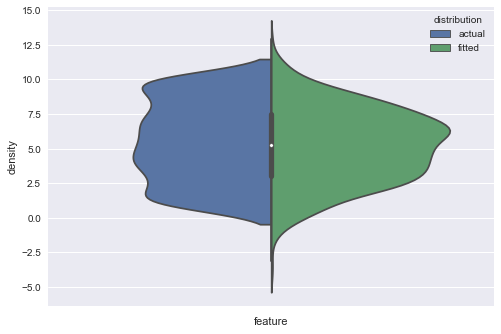

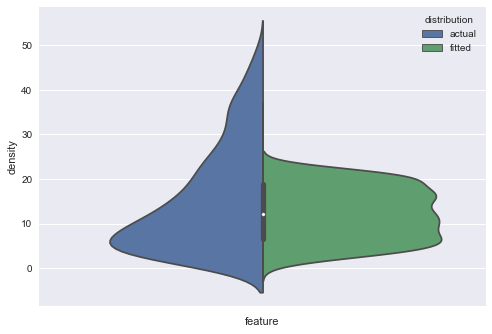

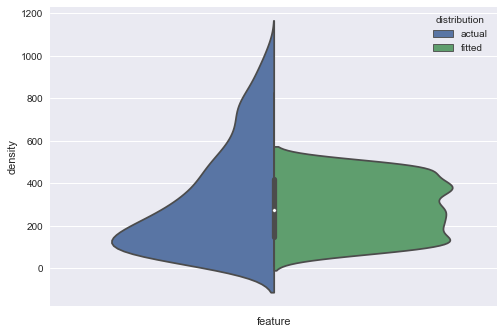

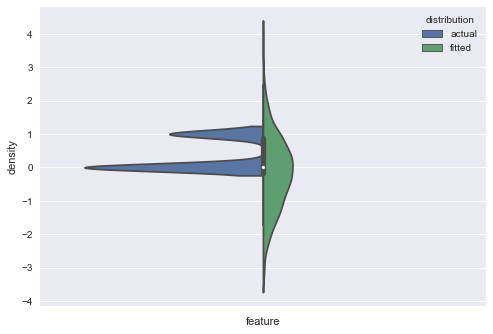

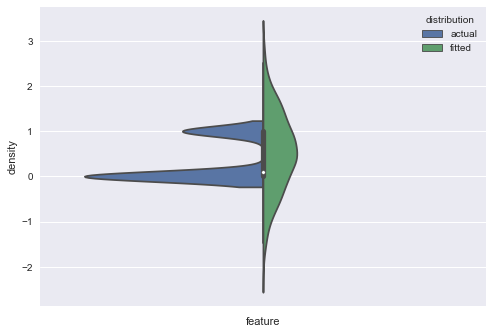

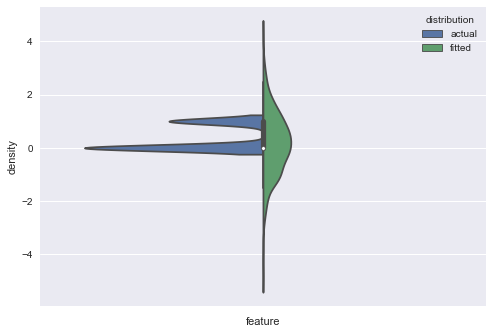

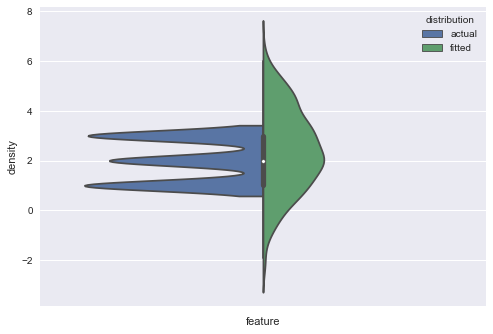

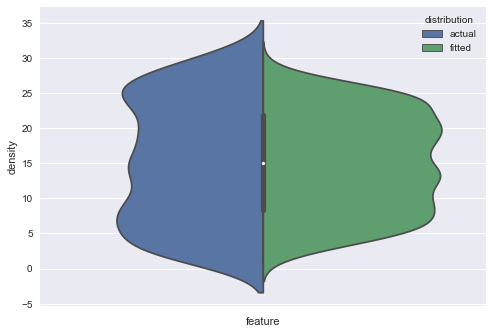

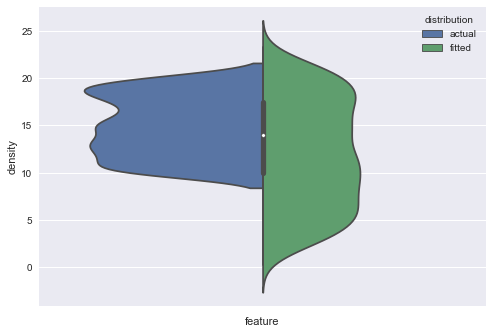

In [22]:
from visualisation.visualisation import Visualisation

y_hat = cgan.sample(X)
cgan_viz = Visualisation(cgan, X, y)
for i in range(y.shape[1]):
    cgan_viz.plot_violin(y[:,i], y_hat[:,i])

In [23]:
from performance.performance import prob_overlap, kl, js

p, q = prob_overlap(y, y_hat, bins=8)
print("KL:", kl(p, q))
print("JS:", js(p, q))

KL: 0.0
JS: 0.0


In [26]:
def prob_overlap(y, y_hat, bins=20):
    """Get probabilities of each bin, ignoring zeroes."""
    p, b = np.histogramdd(y, bins)
    q, _ = np.histogramdd(y_hat, b)
    p, q = p / y.shape[0], q / y.shape[0]
    idx = np.array(np.where(np.logical_and(p != 0, q != 0)))
    return p[tuple(idx)], q[tuple(idx)]

def kl(p, q):
    """Compute KL divergence."""
    return np.sum(p * np.log(p / q))

def js(p, q):
    """Compute JS divergence."""
    m = 0.5 * (p + q)
    return 0.5 * (kl(p, m) + kl(q, m))

In [28]:
p, b = np.histogramdd(y, 8)
q, _ = np.histogramdd(y_hat, b)

In [ ]:
p